In [54]:
import re
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.multioutput import MultiOutputClassifier
from mlxtend.plotting import plot_decision_regions 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import seaborn as sns
import numpy as np

In [55]:
meme_df = pd.read_csv('data/meme_coins_20.csv')
stable_df = pd.read_csv('data/stable_coins_20.csv')
defi_df = defi_df = pd.read_csv('data/defi_coins_20.csv')

In [56]:
meme_df['meme'] = 1
stable_df['stable'] = 1
defi_df['defi'] = 1

In [57]:
def clean_numeric_column(series):
    return series.astype(str).apply(lambda x: re.sub(r'[^\d.-]', '', x))

In [58]:
numeric_columns = ['price', 'market cap', '24h volume', '24h', '7d', '30d']
for df in [meme_df, stable_df, defi_df]:
    for col in numeric_columns:
        if col in df.columns:
            df[col] = clean_numeric_column(df[col])
            df[col] = pd.to_numeric(df[col], errors='coerce')

In [59]:
df = pd.concat([meme_df, stable_df, defi_df], axis=0)
df = df.fillna(0)
df = df.groupby('symbol').agg({
    'name': 'first',
    'price': 'first', 
    'market cap': 'first',
    '24h volume': 'first',
    '24h': 'first',
    '7d': 'first',
    '30d': 'first',
    'meme': 'max',
    'stable': 'max',
    'defi': 'max'
}).reset_index()

df[['meme', 'stable', 'defi']] = df[['meme', 'stable', 'defi']].astype(int)

In [60]:
df.head(5)

,symbol,name,price,market cap,24h volume,24h,7d,30d,meme,stable,defi
0,AAVE,Aave,2.265500e+02,3.46,119.74,-1.70,5.39,-12.96,0,0,1
1,AETHUSDT,Aave Ethereum USDT,1.000000e+00,6.14,94.91,0.02,-0.06,0.04,0,1,1
2,AETHWETH,Aave Ethereum WETH,3.932970e+03,9.45,187.62,-0.59,1.08,1.48,0,0,1
3,B,BUILDon,1.805000e-01,174.89,8.39,7.04,3.34,-63.33,1,0,0
4,BABYDOGE,BABYDOGE,1.028000e-08,176.09,16.18,9.53,0.49,-25.62,1,0,0


In [61]:
df.shape

(55, 11)

In [62]:
df.drop(['name'], axis=1, inplace=True)

In [63]:
df.head()

,symbol,price,market cap,24h volume,24h,7d,30d,meme,stable,defi
0,AAVE,2.265500e+02,3.46,119.74,-1.70,5.39,-12.96,0,0,1
1,AETHUSDT,1.000000e+00,6.14,94.91,0.02,-0.06,0.04,0,1,1
2,AETHWETH,3.932970e+03,9.45,187.62,-0.59,1.08,1.48,0,0,1
3,B,1.805000e-01,174.89,8.39,7.04,3.34,-63.33,1,0,0
4,BABYDOGE,1.028000e-08,176.09,16.18,9.53,0.49,-25.62,1,0,0


In [64]:
df_pca = df.drop(['symbol'], axis=1)
df_pca['24h'] = df_pca['24h'].map(lambda x: abs(float(x)))
df_pca['7d'] = df_pca['7d'].map(lambda x: abs(float(x)))
df_pca['30d'] = df_pca['30d'].map(lambda x: abs(float(x)))

In [65]:
df_pca.head()

,price,market cap,24h volume,24h,7d,30d,meme,stable,defi
0,2.265500e+02,3.46,119.74,1.70,5.39,12.96,0,0,1
1,1.000000e+00,6.14,94.91,0.02,0.06,0.04,0,1,1
2,3.932970e+03,9.45,187.62,0.59,1.08,1.48,0,0,1
3,1.805000e-01,174.89,8.39,7.04,3.34,63.33,1,0,0
4,1.028000e-08,176.09,16.18,9.53,0.49,25.62,1,0,0


In [66]:
standard_scaler = StandardScaler()
df_pca = standard_scaler.fit_transform(df_pca)

In [67]:
pca = PCA()
pca_result = pca.fit_transform(df_pca)

In [68]:
pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])
pca_df['symbol'] = df['symbol'].values

In [69]:
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,symbol
0,-0.672459,1.397190,0.277889,0.246658,-0.757171,0.522826,-0.365604,0.045734,-0.244526,AAVE
1,-2.107739,0.218223,0.120091,0.286200,-0.672019,-0.210162,0.143577,0.738094,0.639274,AETHUSDT
2,-1.332589,1.317378,0.501487,-0.019605,-0.487807,0.701255,-0.026912,-0.430234,-0.051457,AETHWETH
3,2.859840,-0.077565,0.221325,-1.331055,-0.188258,-0.415866,-0.345372,0.906072,-0.384201,B
4,2.073415,-0.115985,-0.022683,-0.651563,-0.266605,-0.555943,1.044493,-0.348226,-0.051300,BABYDOGE


In [70]:
pca_df = pd.concat([pca_df, df['meme'], df['stable'], df['defi']], axis = 1)

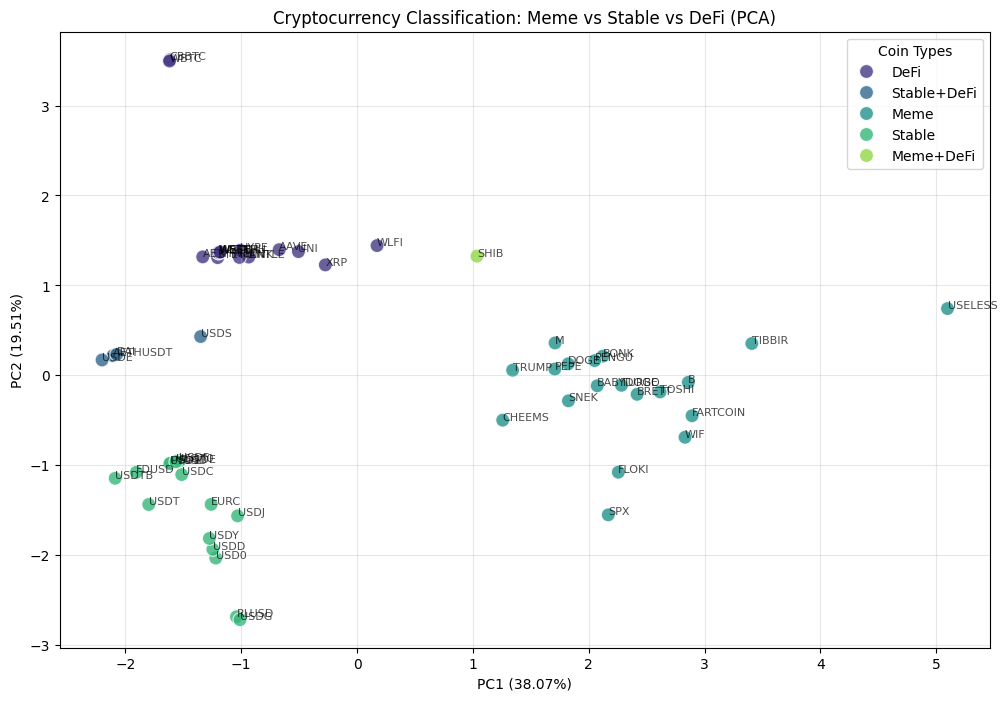

In [71]:
plt.figure(figsize=(12, 8))

def get_class(row):
    if row['meme'] == 1 and row['stable'] == 1 and row['defi'] == 1:
        return 'Meme+Stable+DeFi'
    elif row['meme'] == 1 and row['stable'] == 1:
        return 'Meme+Stable'
    elif row['meme'] == 1 and row['defi'] == 1:
        return 'Meme+DeFi'
    elif row['stable'] == 1 and row['defi'] == 1:
        return 'Stable+DeFi'
    elif row['meme'] == 1:
        return 'Meme'
    elif row['stable'] == 1:
        return 'Stable'
    elif row['defi'] == 1:
        return 'DeFi'
    else:
        return 'Other'

pca_df['Class'] = pca_df.apply(get_class, axis=1)

sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Class', 
                palette='viridis', s=100, alpha=0.8)

for i, row in pca_df.iterrows():
    plt.annotate(row['symbol'], (row['PC1'], row['PC2']), 
                fontsize=8, alpha=0.7)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.title('Cryptocurrency Classification: Meme vs Stable vs DeFi (PCA)')
plt.legend(title='Coin Types')
plt.grid(True, alpha=0.3)
plt.show()

In [72]:
X = pca_df[['PC1', 'PC2']]
y = df[['meme', 'stable', 'defi']]

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [74]:
multi_label_logistic_regression = MultiOutputClassifier(LogisticRegression())
multi_label_logistic_regression.fit(X_train, y_train)

,estimator,LogisticRegression()
,n_jobs,None
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'


/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


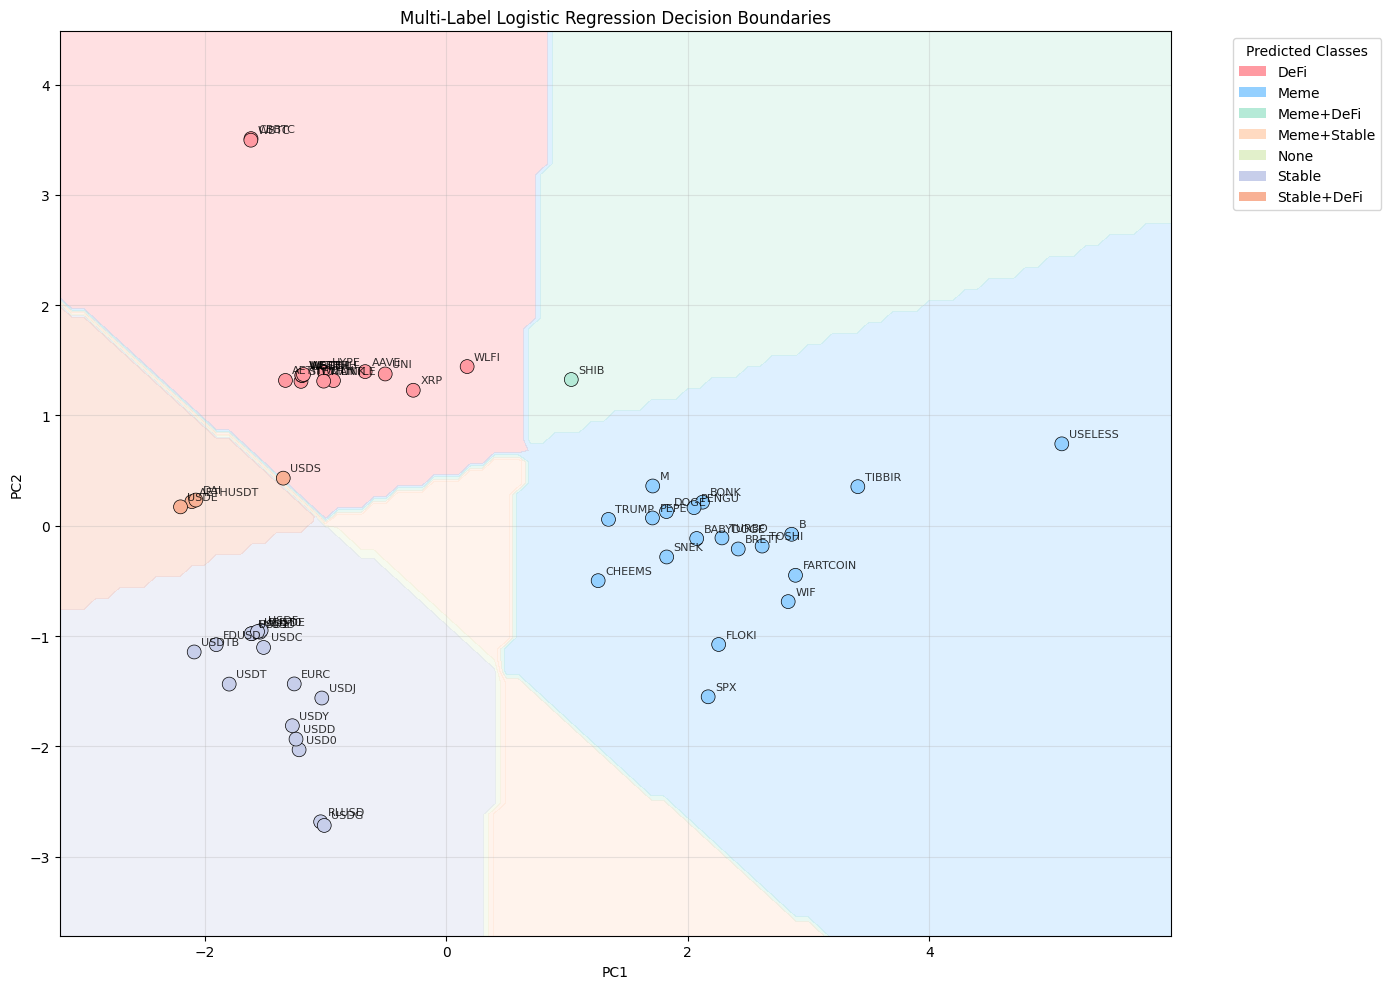

In [75]:
plt.figure(figsize=(14, 10))

x_min, x_max = X['PC1'].min() - 1, X['PC1'].max() + 1
y_min, y_max = X['PC2'].min() - 1, X['PC2'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = multi_label_logistic_regression.predict(np.c_[xx.ravel(), yy.ravel()])

def get_combined_label(prediction):
    labels = []
    if prediction[0] == 1: labels.append('Meme')
    if prediction[1] == 1: labels.append('Stable')
    if prediction[2] == 1: labels.append('DeFi')
    return '+'.join(labels) if labels else 'None'

Z_labels = np.array([get_combined_label(z) for z in Z])

unique_labels = np.unique(Z_labels)
label_to_num = {label: i for i, label in enumerate(unique_labels)}
Z_numeric = np.array([label_to_num[label] for label in Z_labels])
Z_numeric = Z_numeric.reshape(xx.shape)

colors = [
    '#FF9AA2',  # Soft coral pink (Meme)
    '#94D0FF',  # Soft sky blue (Stable) 
    '#B5EAD7',  # Soft mint green (DeFi)
    '#FFDAC1',  # Soft peach (Meme+Stable)
    '#E2F0CB',  # Soft lime (Meme+DeFi)
    '#C7CEEA',  # Soft lavender (Stable+DeFi)
    '#F8B195',  # Soft salmon (Meme+Stable+DeFi)
    '#D8D8D8'   # Soft gray (None)
]
cmap = ListedColormap(colors[:len(unique_labels)])

plt.contourf(xx, yy, Z_numeric, alpha=0.3, cmap=cmap)

plot_df = X.copy()
plot_df['Class'] = y.apply(lambda row: get_combined_label([row['meme'], row['stable'], row['defi']]), axis=1)

scatter = plt.scatter(plot_df['PC1'], plot_df['PC2'], 
                      c=[label_to_num[label] for label in plot_df['Class']], 
                      cmap=cmap, s=100, edgecolors='black', linewidth=0.5)

for i, row in plot_df.iterrows():
    plt.annotate(df.loc[i, 'symbol'], (row['PC1'], row['PC2']), 
                fontsize=8, alpha=0.8, xytext=(5, 5), textcoords='offset points')

plt.xlabel(f'PC1')
plt.ylabel(f'PC2')
plt.title('Multi-Label Logistic Regression Decision Boundaries')

legend_elements = [Patch(facecolor=colors[i], label=label) 
                   for i, label in enumerate(unique_labels)]
plt.legend(handles=legend_elements, title='Predicted Classes', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [76]:
multi_label_knn = MultiOutputClassifier(KNeighborsClassifier())
multi_label_knn.fit(X_train, y_train)

,estimator,KNeighborsClassifier()
,n_jobs,None
,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


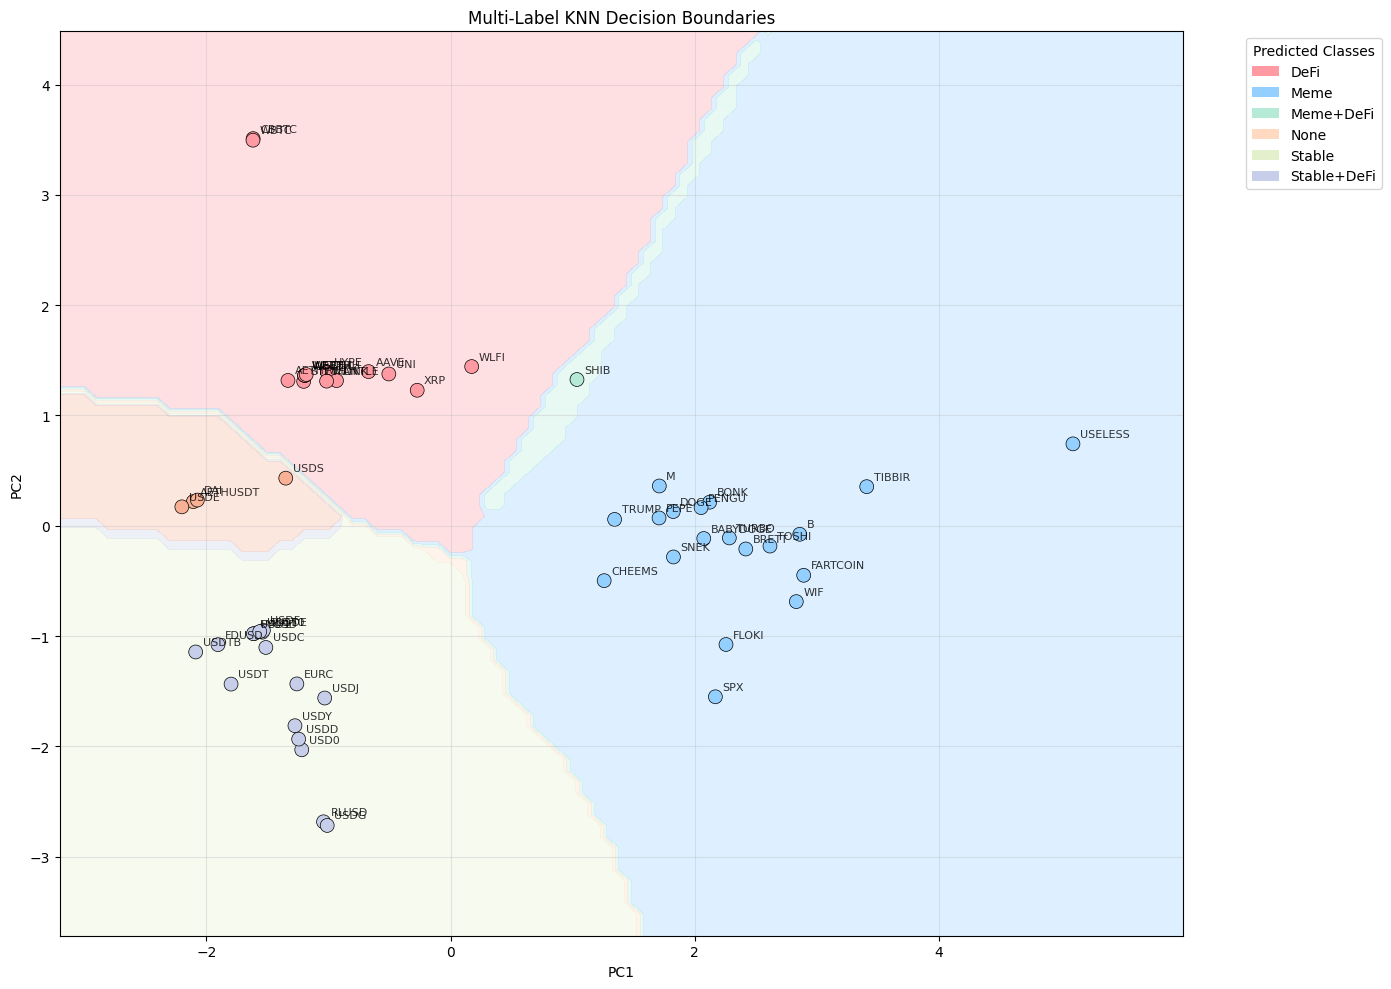

In [77]:
plt.figure(figsize=(14, 10))

x_min, x_max = X['PC1'].min() - 1, X['PC1'].max() + 1
y_min, y_max = X['PC2'].min() - 1, X['PC2'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = multi_label_knn.predict(np.c_[xx.ravel(), yy.ravel()])

def get_combined_label(prediction):
    labels = []
    if prediction[0] == 1: labels.append('Meme')
    if prediction[1] == 1: labels.append('Stable')
    if prediction[2] == 1: labels.append('DeFi')
    return '+'.join(labels) if labels else 'None'

Z_labels = np.array([get_combined_label(z) for z in Z])

unique_labels = np.unique(Z_labels)
label_to_num = {label: i for i, label in enumerate(unique_labels)}
Z_numeric = np.array([label_to_num[label] for label in Z_labels])
Z_numeric = Z_numeric.reshape(xx.shape)

plt.contourf(xx, yy, Z_numeric, alpha=0.3, cmap=cmap)

plot_df = X.copy()
plot_df['Class'] = y.apply(lambda row: get_combined_label([row['meme'], row['stable'], row['defi']]), axis=1)

scatter = plt.scatter(plot_df['PC1'], plot_df['PC2'], 
                      c=[label_to_num[label] for label in plot_df['Class']], 
                      cmap=cmap, s=100, edgecolors='black', linewidth=0.5)

for i, row in plot_df.iterrows():
    plt.annotate(df.loc[i, 'symbol'], (row['PC1'], row['PC2']), 
                fontsize=8, alpha=0.8, xytext=(5, 5), textcoords='offset points')

plt.xlabel(f'PC1')
plt.ylabel(f'PC2')
plt.title('Multi-Label KNN Decision Boundaries')

legend_elements = [Patch(facecolor=colors[i], label=label) 
                   for i, label in enumerate(unique_labels)]
plt.legend(handles=legend_elements, title='Predicted Classes', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [78]:
multi_label_nearest_centroid = MultiOutputClassifier(NearestCentroid())
multi_label_nearest_centroid.fit(X_train, y_train)

,estimator,NearestCentroid()
,n_jobs,None
,metric,'euclidean'
,shrink_threshold,None
,priors,'uniform'


/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but NearestCentroid was fitted with feature names
  warnings.warn(
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but NearestCentroid was fitted with feature names
  warnings.warn(
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but NearestCentroid was fitted with feature names
  warnings.warn(


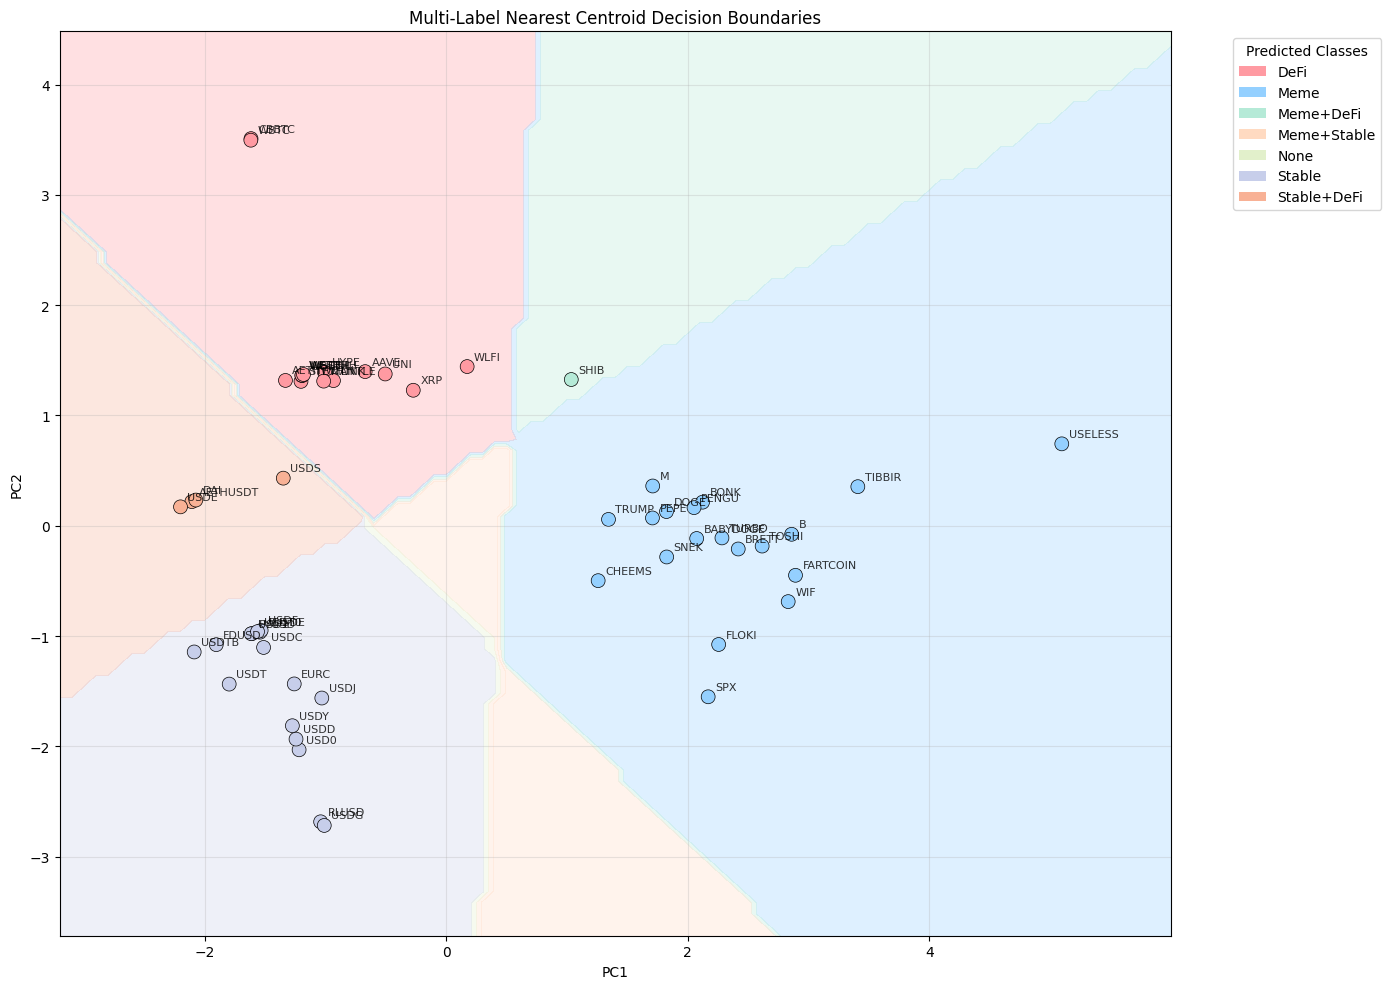

In [79]:
plt.figure(figsize=(14, 10))

x_min, x_max = X['PC1'].min() - 1, X['PC1'].max() + 1
y_min, y_max = X['PC2'].min() - 1, X['PC2'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = multi_label_nearest_centroid.predict(np.c_[xx.ravel(), yy.ravel()])

def get_combined_label(prediction):
    labels = []
    if prediction[0] == 1: labels.append('Meme')
    if prediction[1] == 1: labels.append('Stable')
    if prediction[2] == 1: labels.append('DeFi')
    return '+'.join(labels) if labels else 'None'

Z_labels = np.array([get_combined_label(z) for z in Z])

unique_labels = np.unique(Z_labels)
label_to_num = {label: i for i, label in enumerate(unique_labels)}
Z_numeric = np.array([label_to_num[label] for label in Z_labels])
Z_numeric = Z_numeric.reshape(xx.shape)

plt.contourf(xx, yy, Z_numeric, alpha=0.3, cmap=cmap)

plot_df = X.copy()
plot_df['Class'] = y.apply(lambda row: get_combined_label([row['meme'], row['stable'], row['defi']]), axis=1)

scatter = plt.scatter(plot_df['PC1'], plot_df['PC2'], 
                      c=[label_to_num[label] for label in plot_df['Class']], 
                      cmap=cmap, s=100, edgecolors='black', linewidth=0.5)

for i, row in plot_df.iterrows():
    plt.annotate(df.loc[i, 'symbol'], (row['PC1'], row['PC2']), 
                fontsize=8, alpha=0.8, xytext=(5, 5), textcoords='offset points')

plt.xlabel(f'PC1')
plt.ylabel(f'PC2')
plt.title('Multi-Label Nearest Centroid Decision Boundaries')

legend_elements = [Patch(facecolor=colors[i], label=label) 
                   for i, label in enumerate(unique_labels)]
plt.legend(handles=legend_elements, title='Predicted Classes', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [80]:
multi_label_svc_linear = MultiOutputClassifier(SVC(kernel='linear'))
multi_label_svc_linear.fit(X_train, y_train)

,estimator,SVC(kernel='linear')
,n_jobs,None
,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200


/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


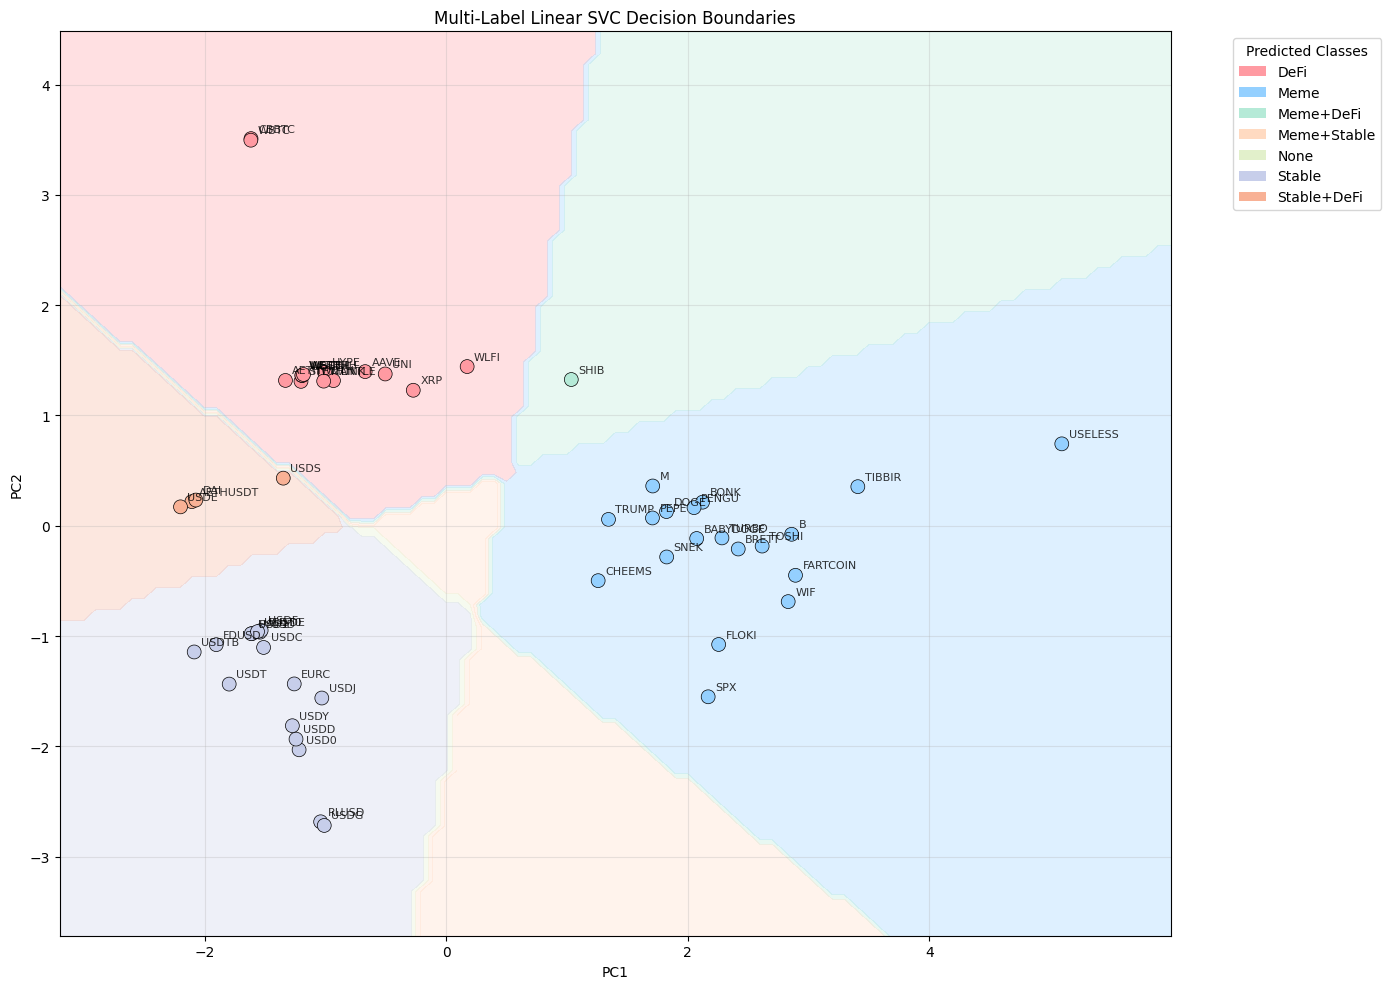

In [81]:
plt.figure(figsize=(14, 10))

x_min, x_max = X['PC1'].min() - 1, X['PC1'].max() + 1
y_min, y_max = X['PC2'].min() - 1, X['PC2'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = multi_label_svc_linear.predict(np.c_[xx.ravel(), yy.ravel()])

def get_combined_label(prediction):
    labels = []
    if prediction[0] == 1: labels.append('Meme')
    if prediction[1] == 1: labels.append('Stable')
    if prediction[2] == 1: labels.append('DeFi')
    return '+'.join(labels) if labels else 'None'

Z_labels = np.array([get_combined_label(z) for z in Z])

unique_labels = np.unique(Z_labels)
label_to_num = {label: i for i, label in enumerate(unique_labels)}
Z_numeric = np.array([label_to_num[label] for label in Z_labels])
Z_numeric = Z_numeric.reshape(xx.shape)

plt.contourf(xx, yy, Z_numeric, alpha=0.3, cmap=cmap)

plot_df = X.copy()
plot_df['Class'] = y.apply(lambda row: get_combined_label([row['meme'], row['stable'], row['defi']]), axis=1)

scatter = plt.scatter(plot_df['PC1'], plot_df['PC2'], 
                      c=[label_to_num[label] for label in plot_df['Class']], 
                      cmap=cmap, s=100, edgecolors='black', linewidth=0.5)

for i, row in plot_df.iterrows():
    plt.annotate(df.loc[i, 'symbol'], (row['PC1'], row['PC2']), 
                fontsize=8, alpha=0.8, xytext=(5, 5), textcoords='offset points')

plt.xlabel(f'PC1')
plt.ylabel(f'PC2')
plt.title('Multi-Label Linear SVC Decision Boundaries')

legend_elements = [Patch(facecolor=colors[i], label=label) 
                   for i, label in enumerate(unique_labels)]
plt.legend(handles=legend_elements, title='Predicted Classes', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [82]:
multi_label_svc_poly = MultiOutputClassifier(SVC(C=10, kernel='poly'))
multi_label_svc_poly.fit(X_train, y_train)

,estimator,"SVC(C=10, kernel='poly')"
,n_jobs,None
,C,10
,kernel,'poly'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200


/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


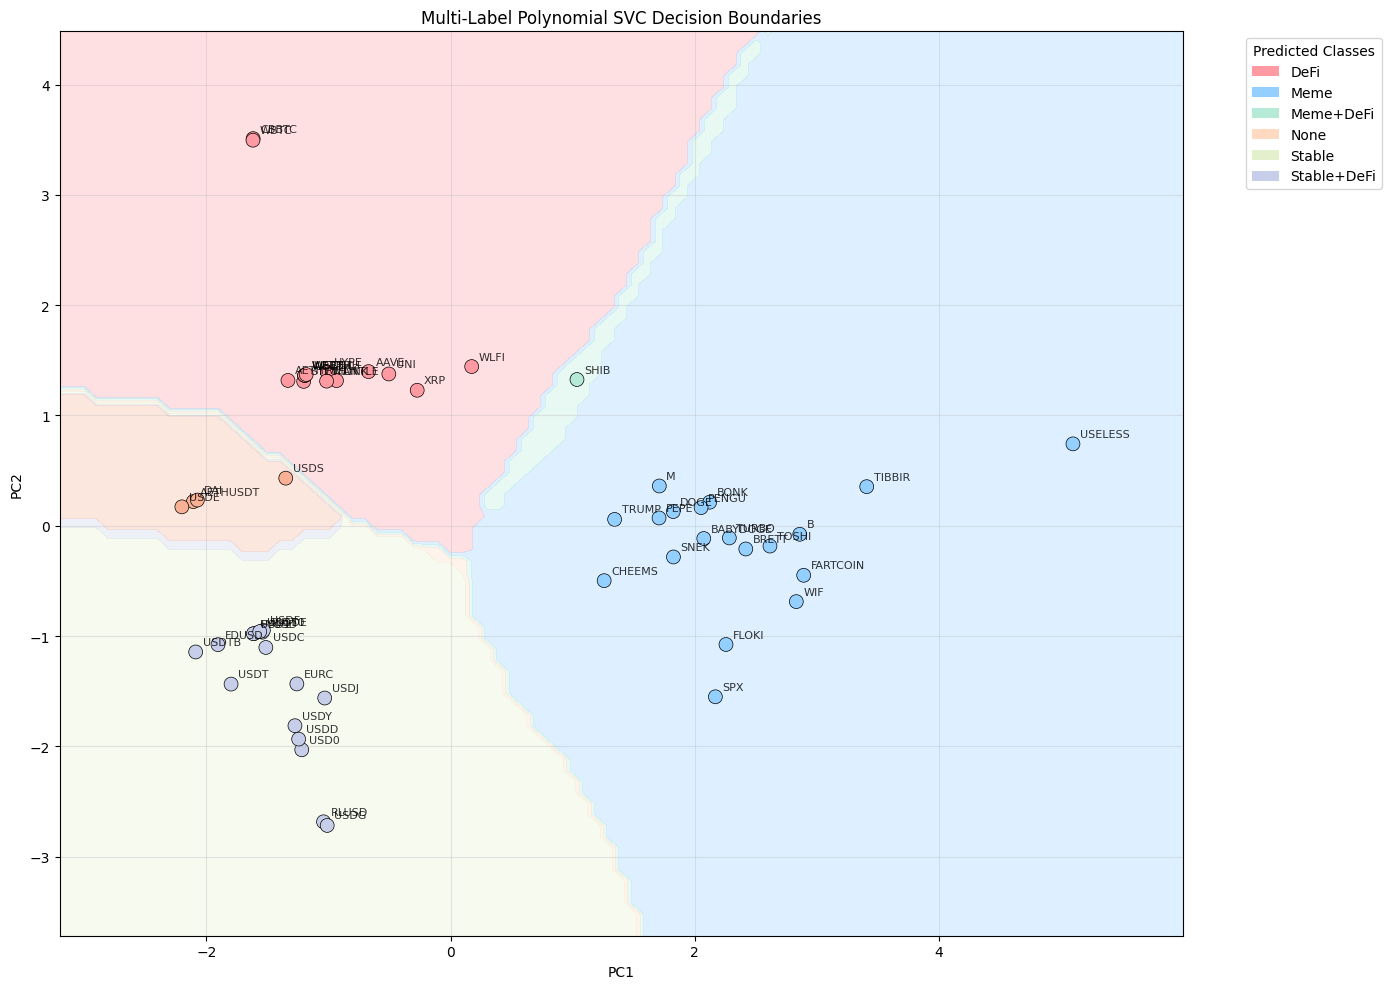

In [83]:
plt.figure(figsize=(14, 10))

x_min, x_max = X['PC1'].min() - 1, X['PC1'].max() + 1
y_min, y_max = X['PC2'].min() - 1, X['PC2'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = multi_label_knn.predict(np.c_[xx.ravel(), yy.ravel()])

def get_combined_label(prediction):
    labels = []
    if prediction[0] == 1: labels.append('Meme')
    if prediction[1] == 1: labels.append('Stable')
    if prediction[2] == 1: labels.append('DeFi')
    return '+'.join(labels) if labels else 'None'

Z_labels = np.array([get_combined_label(z) for z in Z])

unique_labels = np.unique(Z_labels)
label_to_num = {label: i for i, label in enumerate(unique_labels)}
Z_numeric = np.array([label_to_num[label] for label in Z_labels])
Z_numeric = Z_numeric.reshape(xx.shape)

plt.contourf(xx, yy, Z_numeric, alpha=0.3, cmap=cmap)

plot_df = X.copy()
plot_df['Class'] = y.apply(lambda row: get_combined_label([row['meme'], row['stable'], row['defi']]), axis=1)

scatter = plt.scatter(plot_df['PC1'], plot_df['PC2'], 
                      c=[label_to_num[label] for label in plot_df['Class']], 
                      cmap=cmap, s=100, edgecolors='black', linewidth=0.5)

for i, row in plot_df.iterrows():
    plt.annotate(df.loc[i, 'symbol'], (row['PC1'], row['PC2']), 
                fontsize=8, alpha=0.8, xytext=(5, 5), textcoords='offset points')

plt.xlabel(f'PC1')
plt.ylabel(f'PC2')
plt.title('Multi-Label Polynomial SVC Decision Boundaries')

legend_elements = [Patch(facecolor=colors[i], label=label) 
                   for i, label in enumerate(unique_labels)]
plt.legend(handles=legend_elements, title='Predicted Classes', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [84]:
multi_label_svc_rbf = MultiOutputClassifier(SVC(C=10, kernel='rbf'))
multi_label_svc_rbf.fit(X_train, y_train)

,estimator,SVC(C=10)
,n_jobs,None
,C,10
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200


/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


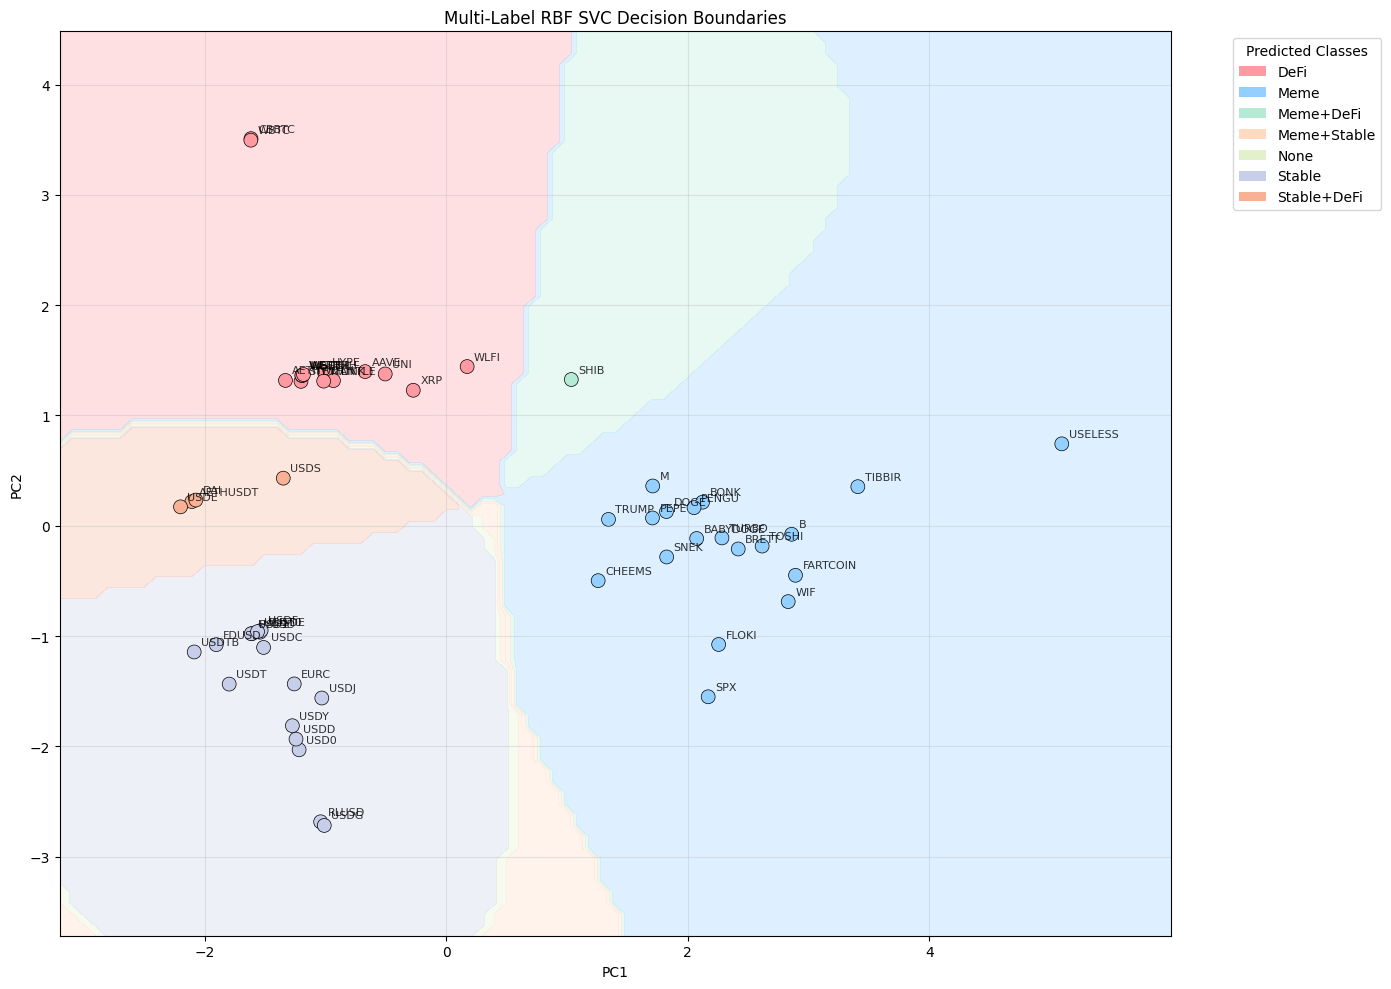

In [85]:
plt.figure(figsize=(14, 10))

x_min, x_max = X['PC1'].min() - 1, X['PC1'].max() + 1
y_min, y_max = X['PC2'].min() - 1, X['PC2'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = multi_label_svc_rbf.predict(np.c_[xx.ravel(), yy.ravel()])

def get_combined_label(prediction):
    labels = []
    if prediction[0] == 1: labels.append('Meme')
    if prediction[1] == 1: labels.append('Stable')
    if prediction[2] == 1: labels.append('DeFi')
    return '+'.join(labels) if labels else 'None'

Z_labels = np.array([get_combined_label(z) for z in Z])

unique_labels = np.unique(Z_labels)
label_to_num = {label: i for i, label in enumerate(unique_labels)}
Z_numeric = np.array([label_to_num[label] for label in Z_labels])
Z_numeric = Z_numeric.reshape(xx.shape)

plt.contourf(xx, yy, Z_numeric, alpha=0.3, cmap=cmap)

plot_df = X.copy()
plot_df['Class'] = y.apply(lambda row: get_combined_label([row['meme'], row['stable'], row['defi']]), axis=1)

scatter = plt.scatter(plot_df['PC1'], plot_df['PC2'], 
                      c=[label_to_num[label] for label in plot_df['Class']], 
                      cmap=cmap, s=100, edgecolors='black', linewidth=0.5)

for i, row in plot_df.iterrows():
    plt.annotate(df.loc[i, 'symbol'], (row['PC1'], row['PC2']), 
                fontsize=8, alpha=0.8, xytext=(5, 5), textcoords='offset points')

plt.xlabel(f'PC1')
plt.ylabel(f'PC2')
plt.title('Multi-Label RBF SVC Decision Boundaries')

legend_elements = [Patch(facecolor=colors[i], label=label) 
                   for i, label in enumerate(unique_labels)]
plt.legend(handles=legend_elements, title='Predicted Classes', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [86]:
multi_label_svc_sigmoid = MultiOutputClassifier(SVC(kernel='sigmoid'))
multi_label_svc_sigmoid.fit(X_train, y_train)

,estimator,SVC(kernel='sigmoid')
,n_jobs,None
,C,1.0
,kernel,'sigmoid'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200


/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


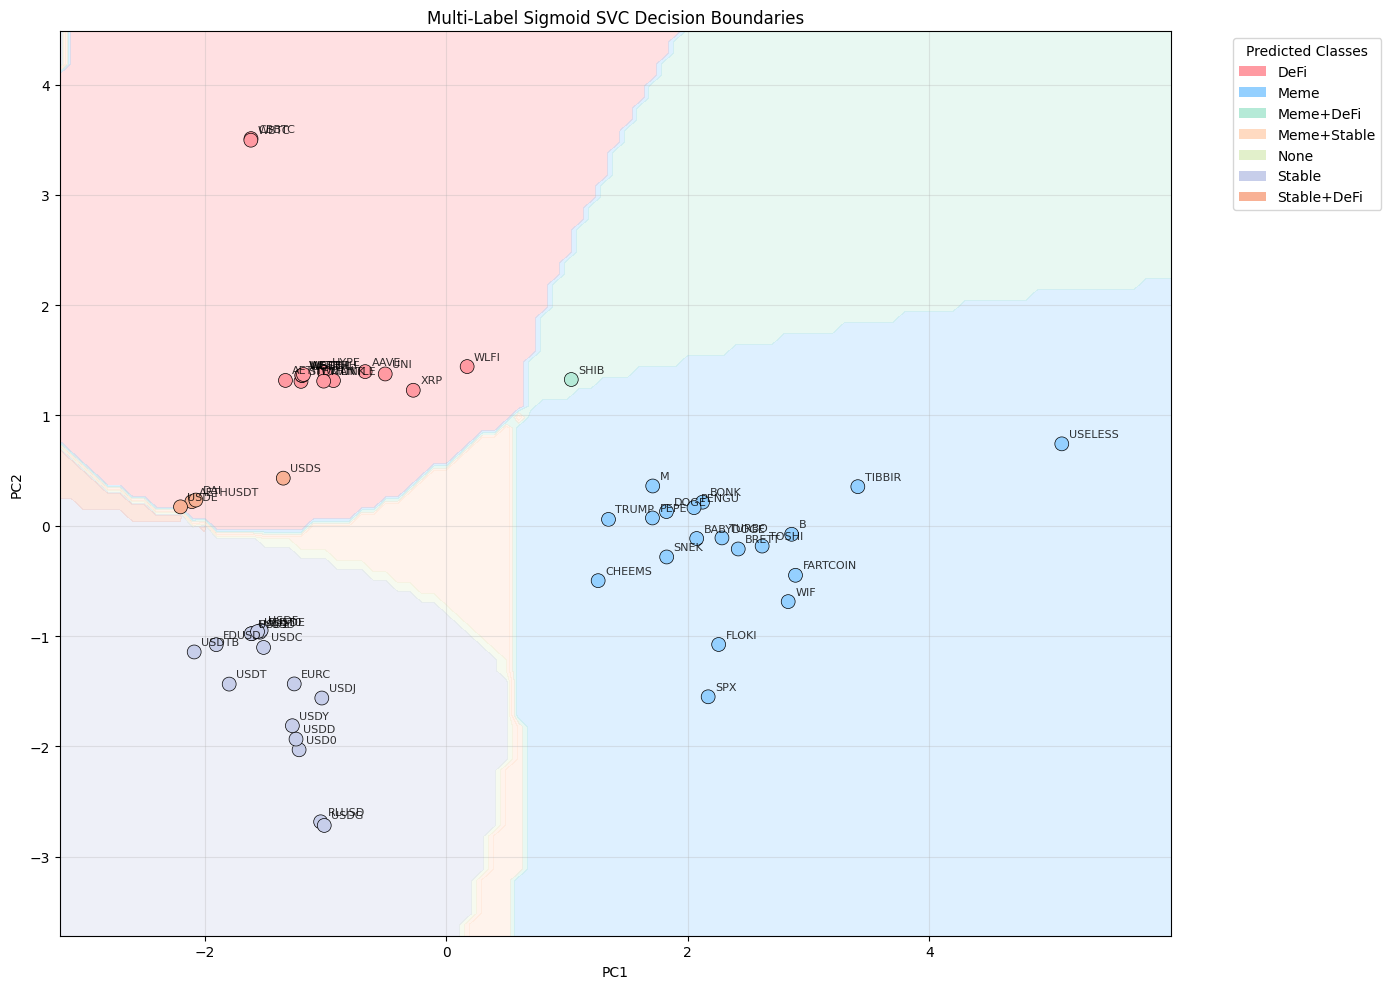

In [87]:
plt.figure(figsize=(14, 10))

x_min, x_max = X['PC1'].min() - 1, X['PC1'].max() + 1
y_min, y_max = X['PC2'].min() - 1, X['PC2'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = multi_label_svc_sigmoid.predict(np.c_[xx.ravel(), yy.ravel()])

def get_combined_label(prediction):
    labels = []
    if prediction[0] == 1: labels.append('Meme')
    if prediction[1] == 1: labels.append('Stable')
    if prediction[2] == 1: labels.append('DeFi')
    return '+'.join(labels) if labels else 'None'

Z_labels = np.array([get_combined_label(z) for z in Z])

unique_labels = np.unique(Z_labels)
label_to_num = {label: i for i, label in enumerate(unique_labels)}
Z_numeric = np.array([label_to_num[label] for label in Z_labels])
Z_numeric = Z_numeric.reshape(xx.shape)

plt.contourf(xx, yy, Z_numeric, alpha=0.3, cmap=cmap)

plot_df = X.copy()
plot_df['Class'] = y.apply(lambda row: get_combined_label([row['meme'], row['stable'], row['defi']]), axis=1)

scatter = plt.scatter(plot_df['PC1'], plot_df['PC2'], 
                      c=[label_to_num[label] for label in plot_df['Class']], 
                      cmap=cmap, s=100, edgecolors='black', linewidth=0.5)

for i, row in plot_df.iterrows():
    plt.annotate(df.loc[i, 'symbol'], (row['PC1'], row['PC2']), 
                fontsize=8, alpha=0.8, xytext=(5, 5), textcoords='offset points')

plt.xlabel(f'PC1')
plt.ylabel(f'PC2')
plt.title('Multi-Label Sigmoid SVC Decision Boundaries')

legend_elements = [Patch(facecolor=colors[i], label=label) 
                   for i, label in enumerate(unique_labels)]
plt.legend(handles=legend_elements, title='Predicted Classes', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [88]:
multi_label_tree = MultiOutputClassifier(DecisionTreeClassifier())
multi_label_tree.fit(X_train, y_train)

,estimator,DecisionTreeClassifier()
,n_jobs,None
,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None


/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


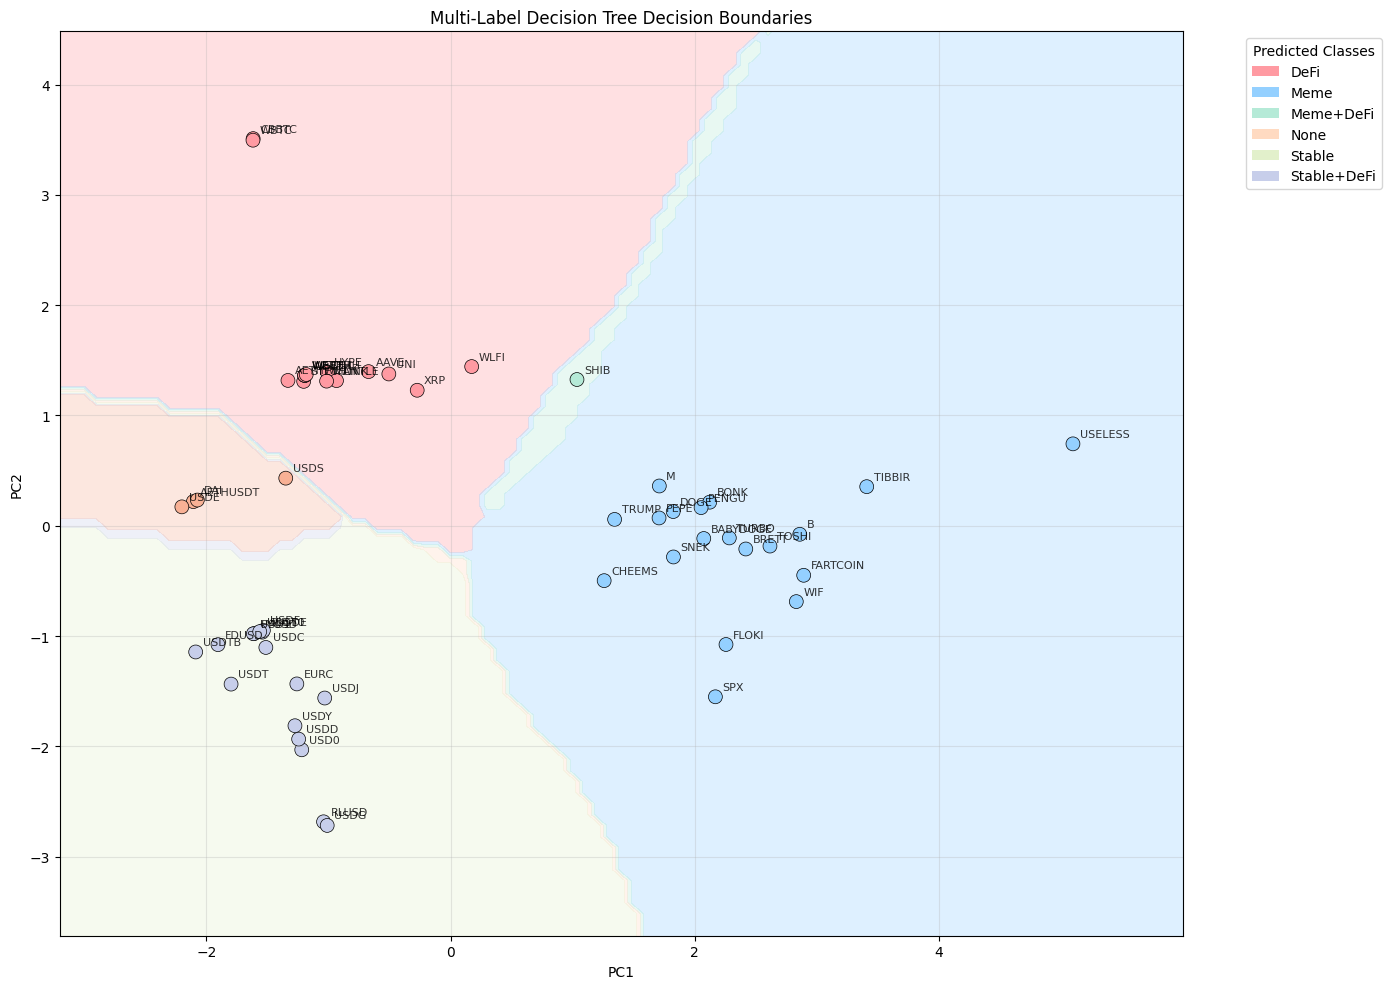

In [89]:
plt.figure(figsize=(14, 10))

x_min, x_max = X['PC1'].min() - 1, X['PC1'].max() + 1
y_min, y_max = X['PC2'].min() - 1, X['PC2'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = multi_label_knn.predict(np.c_[xx.ravel(), yy.ravel()])

def get_combined_label(prediction):
    labels = []
    if prediction[0] == 1: labels.append('Meme')
    if prediction[1] == 1: labels.append('Stable')
    if prediction[2] == 1: labels.append('DeFi')
    return '+'.join(labels) if labels else 'None'

Z_labels = np.array([get_combined_label(z) for z in Z])

unique_labels = np.unique(Z_labels)
label_to_num = {label: i for i, label in enumerate(unique_labels)}
Z_numeric = np.array([label_to_num[label] for label in Z_labels])
Z_numeric = Z_numeric.reshape(xx.shape)

plt.contourf(xx, yy, Z_numeric, alpha=0.3, cmap=cmap)

plot_df = X.copy()
plot_df['Class'] = y.apply(lambda row: get_combined_label([row['meme'], row['stable'], row['defi']]), axis=1)

scatter = plt.scatter(plot_df['PC1'], plot_df['PC2'], 
                      c=[label_to_num[label] for label in plot_df['Class']], 
                      cmap=cmap, s=100, edgecolors='black', linewidth=0.5)

for i, row in plot_df.iterrows():
    plt.annotate(df.loc[i, 'symbol'], (row['PC1'], row['PC2']), 
                fontsize=8, alpha=0.8, xytext=(5, 5), textcoords='offset points')

plt.xlabel(f'PC1')
plt.ylabel(f'PC2')
plt.title('Multi-Label Decision Tree Decision Boundaries')

legend_elements = [Patch(facecolor=colors[i], label=label) 
                   for i, label in enumerate(unique_labels)]
plt.legend(handles=legend_elements, title='Predicted Classes', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [90]:
trials = 100

logistic_regression_accuracy = 0
knn_accuracy = 0
nearest_centroid_accuracy = 0
svc_linear_accuracy = 0
svc_poly_accuracy = 0
svc_rbf_accuracy = 0
svc_sigmoid_accuracy = 0
tree_accuracy = 0

logistic_regression_y_pred = 0
knn_y_pred = 0
nearest_centroid_y_pred = 0
svc_linear_y_pred = 0
svc_poly_y_pred = 0
svc_rbf_y_pred = 0
svc_sigmoid_y_pred = 0
tree_y_pred = 0

accuracies = [
    logistic_regression_accuracy,
    knn_accuracy,
    nearest_centroid_accuracy,
    svc_linear_accuracy,
    svc_poly_accuracy,
    svc_rbf_accuracy,
    svc_sigmoid_accuracy,
    tree_accuracy
]

predictions = [
    logistic_regression_y_pred,
    knn_y_pred,
    nearest_centroid_y_pred,
    svc_linear_y_pred,
    svc_poly_y_pred,
    svc_rbf_y_pred,
    svc_sigmoid_y_pred,
    tree_y_pred
]

models = [
    multi_label_logistic_regression,
    multi_label_knn,
    multi_label_nearest_centroid,
    multi_label_svc_linear,
    multi_label_svc_poly,
    multi_label_svc_rbf,
    multi_label_svc_sigmoid,
    multi_label_tree
]

for i in range(trials):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    for i in range(len(models)):
        models[i].fit(X_train, y_train)
        predictions[i] = models[i].predict(X_test)
        accuracies[i] += accuracy_score(y_test, predictions[i], normalize=True)

for i in range(len(accuracies)):
    accuracies[i] *= (100 / trials)

In [91]:
print(f"Accuracy of logistic regression: {accuracies[0]}%")
print(f"Accuracy of KNN: {accuracies[1]}%")
print(f"Accuracy of nearest centroid: {accuracies[2]}%")
print(f"Accuracy of linear SVC: {accuracies[3]}%")
print(f"Accuracy of polynomial SVC: {accuracies[4]}%")
print(f"Accuracy of RBF SVC: {accuracies[5]}%")
print(f"Accuracy of sigmoid SVC: {accuracies[6]}%")
print(f"Accuracy of decision trees: {accuracies[7]}%")

Accuracy of logistic regression: 98.35714285714289%
Accuracy of KNN: 93.42857142857146%
Accuracy of nearest centroid: 91.57142857142857%
Accuracy of linear SVC: 99.42857142857144%
Accuracy of polynomial SVC: 95.8571428571429%
Accuracy of RBF SVC: 96.64285714285718%
Accuracy of sigmoid SVC: 96.71428571428577%
Accuracy of decision trees: 86.28571428571433%


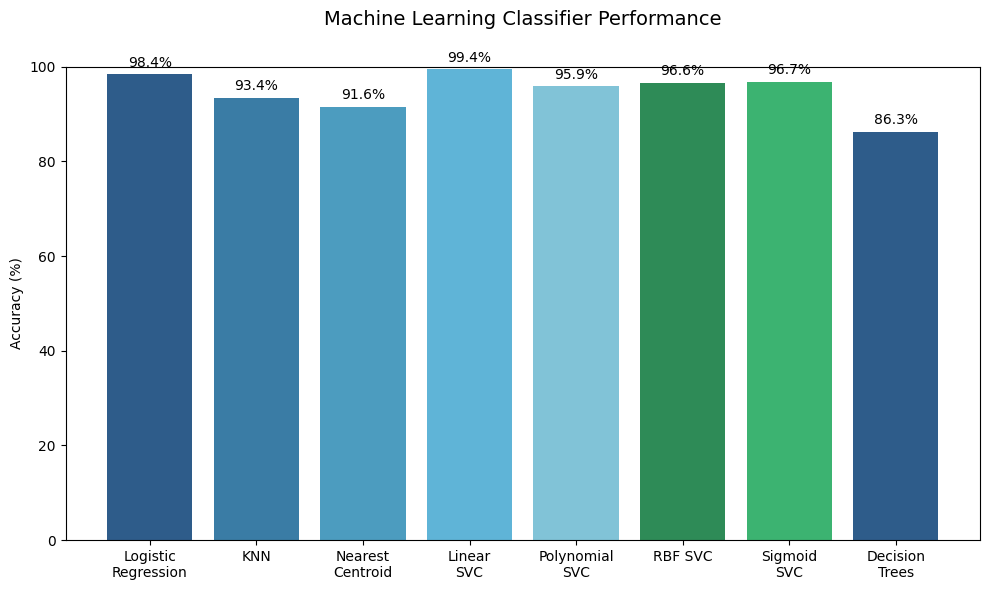

In [92]:
classifiers = ['Logistic\nRegression', 'KNN', 'Nearest\nCentroid', 'Linear\nSVC', 'Polynomial\nSVC', 
               'RBF SVC', 'Sigmoid\nSVC', 'Decision\nTrees']

plt.figure(figsize=(10, 6))
bars = plt.bar(classifiers, accuracies, color = ['#2E5C8A', '#3A7CA5', '#4C9CBF', '#5FB4D7', '#81C3D7', 
                '#2E8B57', '#3CB371'])

plt.ylim(0, 100)
plt.ylabel('Accuracy (%)')
plt.title('Machine Learning Classifier Performance', pad=30, fontsize=14)
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{acc:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [93]:
def namestr(obj, namespace=globals()):
    return [name for name in namespace if namespace[name] is obj]

In [94]:
from sklearn.metrics import accuracy_score, hamming_loss, classification_report

for i in range(len(models)):
    print(f"{namestr(models[i])} Classification Results:\n")
    print(f"Hamming Loss: {hamming_loss(y_test, predictions[i]):.3f}")
    print("\nClassification Report per label:")
    print(classification_report(y_test, predictions[i]) + "\n")

['multi_label_logistic_regression', '_74'] Classification Results:

Hamming Loss: 0.000

Classification Report per label:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         6

   micro avg       1.00      1.00      1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14
 samples avg       1.00      1.00      1.00        14


['multi_label_knn', '_76'] Classification Results:

Hamming Loss: 0.000

Classification Report per label:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         6

   micro avg       1.00      1.00      1.00        14
   macro avg       1.00      1.00      1.00        14
weighted a

/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


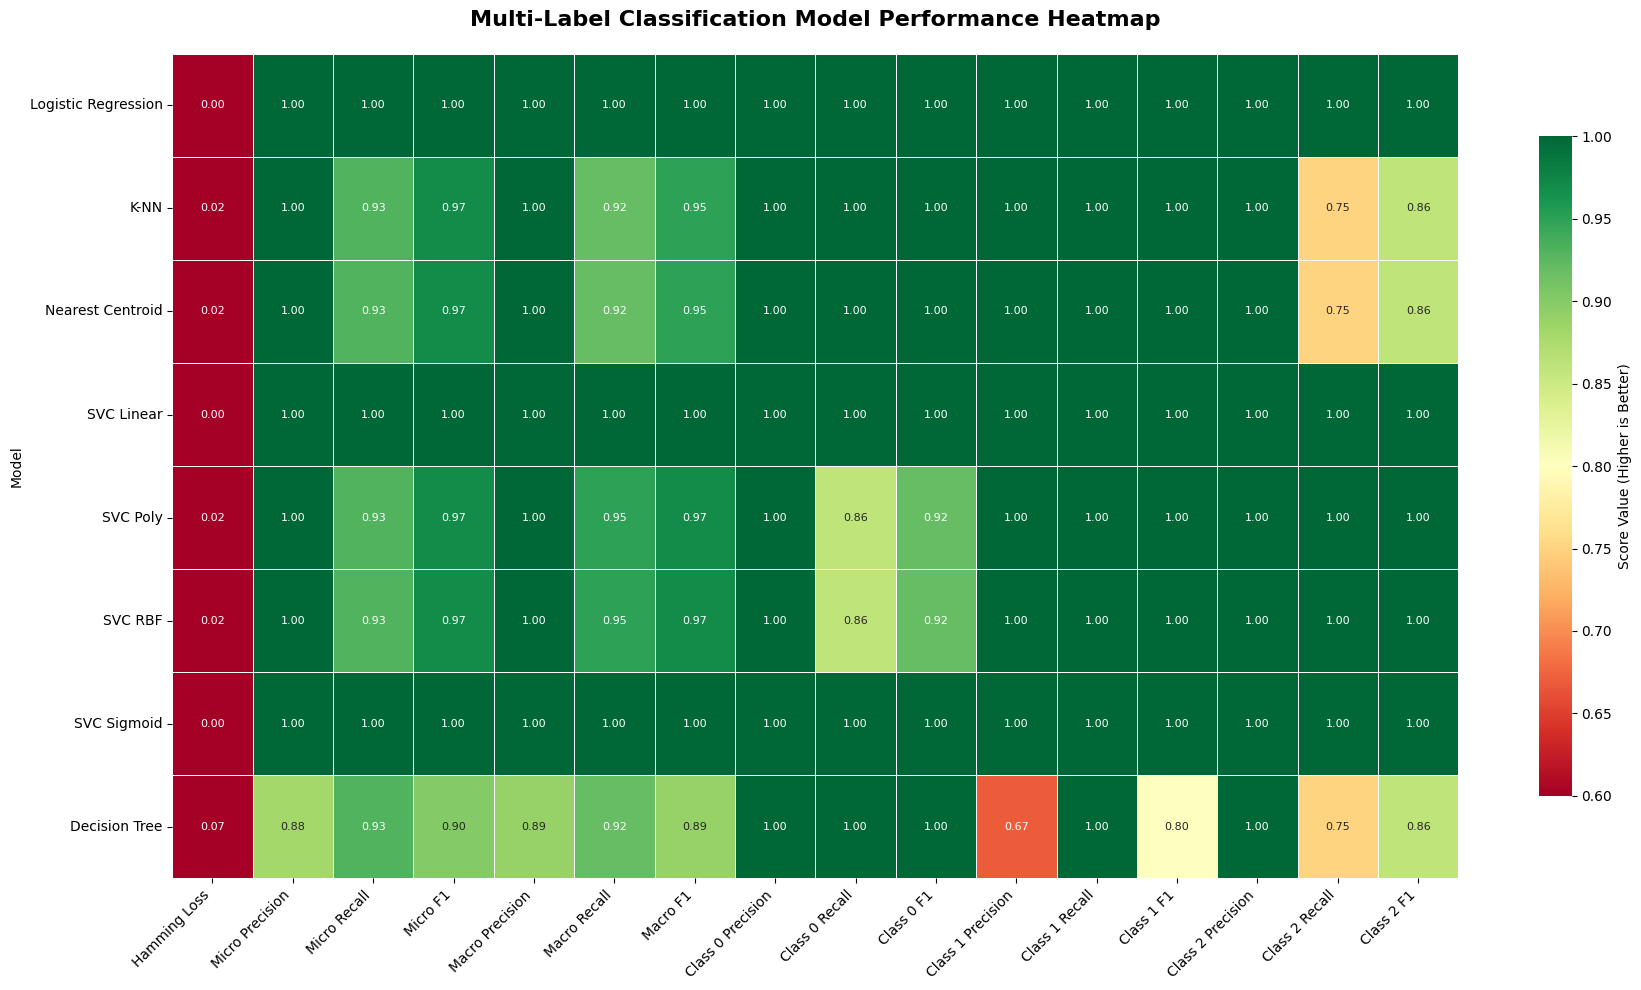

In [95]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create comprehensive dataframe for heatmap
metrics_data = {
    'Model': ['Logistic Regression', 'K-NN', 'Nearest Centroid', 'SVC Linear', 
              'SVC Poly', 'SVC RBF', 'SVC Sigmoid', 'Decision Tree'],
    'Hamming Loss': [0.000, 0.024, 0.024, 0.000, 0.024, 0.024, 0.000, 0.071],
    
    # Micro averages
    'Micro Precision': [1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.88],
    'Micro Recall': [1.00, 0.93, 0.93, 1.00, 0.93, 0.93, 1.00, 0.93],
    'Micro F1': [1.00, 0.97, 0.97, 1.00, 0.97, 0.97, 1.00, 0.90],
    
    # Macro averages
    'Macro Precision': [1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.89],
    'Macro Recall': [1.00, 0.92, 0.92, 1.00, 0.95, 0.95, 1.00, 0.92],
    'Macro F1': [1.00, 0.95, 0.95, 1.00, 0.97, 0.97, 1.00, 0.89],
    
    # Class 0 metrics
    'Class 0 Precision': [1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00],
    'Class 0 Recall': [1.00, 1.00, 1.00, 1.00, 0.86, 0.86, 1.00, 1.00],
    'Class 0 F1': [1.00, 1.00, 1.00, 1.00, 0.92, 0.92, 1.00, 1.00],
    
    # Class 1 metrics
    'Class 1 Precision': [1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.67],
    'Class 1 Recall': [1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00],
    'Class 1 F1': [1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.80],
    
    # Class 2 metrics
    'Class 2 Precision': [1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00],
    'Class 2 Recall': [1.00, 0.75, 0.75, 1.00, 1.00, 1.00, 1.00, 0.75],
    'Class 2 F1': [1.00, 0.86, 0.86, 1.00, 1.00, 1.00, 1.00, 0.86]
}

df = pd.DataFrame(metrics_data)
df.set_index('Model', inplace=True)

# Create the heatmap
plt.figure(figsize=(18, 10))

sns.heatmap(df, 
            annot=True, 
            cmap='RdYlGn', 
            vmin=0.6,
            vmax=1.0,
            center=0.8,
            fmt='.2f', 
            linewidths=0.5, 
            linecolor='white',
            cbar_kws={'label': 'Score Value (Higher is Better)', 'shrink': 0.8},
            annot_kws={'size': 8})

plt.title('Multi-Label Classification Model Performance Heatmap', 
          fontsize=16, pad=20, weight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

SIMPLE RANKING RESULTS (No Weighting):
1. Logistic Regression  | Avg Rank: 2.50
2. SVC Sigmoid          | Avg Rank: 2.50
3. K-NN                 | Avg Rank: 4.42
4. Nearest Centroid     | Avg Rank: 4.42
5. SVC Linear           | Avg Rank: 4.50
6. Decision Tree        | Avg Rank: 5.50
7. SVC Poly             | Avg Rank: 6.08
8. SVC RBF              | Avg Rank: 6.08


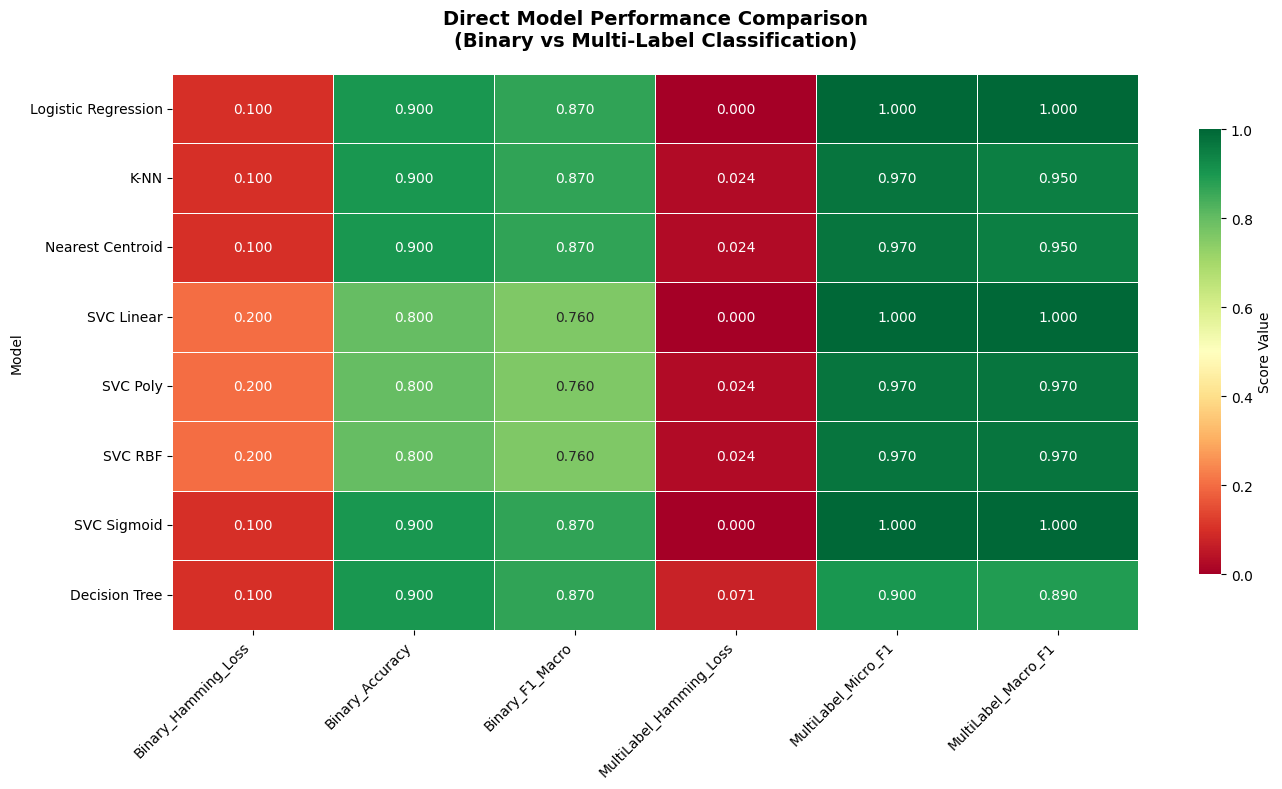

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Your binary classification data
binary_data = {
    'Model': ['Logistic Regression', 'K-NN', 'Nearest Centroid', 'SVC Linear', 
              'SVC Poly', 'SVC RBF', 'SVC Sigmoid', 'Decision Tree'],
    'Binary_Hamming_Loss': [0.100, 0.100, 0.100, 0.200, 0.200, 0.200, 0.100, 0.100],
    'Binary_Accuracy': [0.90, 0.90, 0.90, 0.80, 0.80, 0.80, 0.90, 0.90],
    'Binary_F1_Macro': [0.87, 0.87, 0.87, 0.76, 0.76, 0.76, 0.87, 0.87],
}

# Your multi-label classification data
multilabel_data = {
    'Model': ['Logistic Regression', 'K-NN', 'Nearest Centroid', 'SVC Linear', 
              'SVC Poly', 'SVC RBF', 'SVC Sigmoid', 'Decision Tree'],
    'MultiLabel_Hamming_Loss': [0.000, 0.024, 0.024, 0.000, 0.024, 0.024, 0.000, 0.071],
    'MultiLabel_Micro_F1': [1.00, 0.97, 0.97, 1.00, 0.97, 0.97, 1.00, 0.90],
    'MultiLabel_Macro_F1': [1.00, 0.95, 0.95, 1.00, 0.97, 0.97, 1.00, 0.89],
}

# Create DataFrames and merge
df_binary = pd.DataFrame(binary_data)
df_multi = pd.DataFrame(multilabel_data)
df_combined = pd.merge(df_binary, df_multi, on='Model')

# METHOD 1: Simple Ranking (No Weighting)
# Calculate ranks for each metric (lower rank = better performance)
metrics = ['Binary_Hamming_Loss', 'Binary_Accuracy', 'Binary_F1_Macro', 
           'MultiLabel_Hamming_Loss', 'MultiLabel_Micro_F1', 'MultiLabel_Macro_F1']

# For metrics where lower is better (Hamming Loss), rank ascending
# For metrics where higher is better, rank descending
df_ranks = df_combined.copy()
for metric in metrics:
    if 'Hamming_Loss' in metric:
        df_ranks[f'{metric}_Rank'] = df_combined[metric].rank(ascending=True)
    else:
        df_ranks[f'{metric}_Rank'] = df_combined[metric].rank(ascending=False)

# Calculate average rank across all metrics
rank_columns = [f'{metric}_Rank' for metric in metrics]
df_ranks['Average_Rank'] = df_ranks[rank_columns].mean(axis=1)
df_ranks['Overall_Rank'] = df_ranks['Average_Rank'].rank(ascending=True)

# Sort by overall rank
df_ranks = df_ranks.sort_values('Overall_Rank')

print("SIMPLE RANKING RESULTS (No Weighting):")
print("=" * 50)
for i, (idx, row) in enumerate(df_ranks.iterrows(), 1):
    print(f"{i}. {row['Model']:20} | Avg Rank: {row['Average_Rank']:.2f}")

# Create comparison heatmap without weighted scores
comparison_metrics = [
    'Binary_Hamming_Loss', 'Binary_Accuracy', 'Binary_F1_Macro',
    'MultiLabel_Hamming_Loss', 'MultiLabel_Micro_F1', 'MultiLabel_Macro_F1'
]

df_comparison = df_combined.set_index('Model')[comparison_metrics]

plt.figure(figsize=(14, 8))
sns.heatmap(df_comparison, 
            annot=True, 
            cmap='RdYlGn', 
            fmt='.3f', 
            linewidths=0.5, 
            linecolor='white',
            cbar_kws={'label': 'Score Value', 'shrink': 0.8},
            annot_kws={'size': 10})

plt.title('Direct Model Performance Comparison\n(Binary vs Multi-Label Classification)', 
          fontsize=14, pad=20, weight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

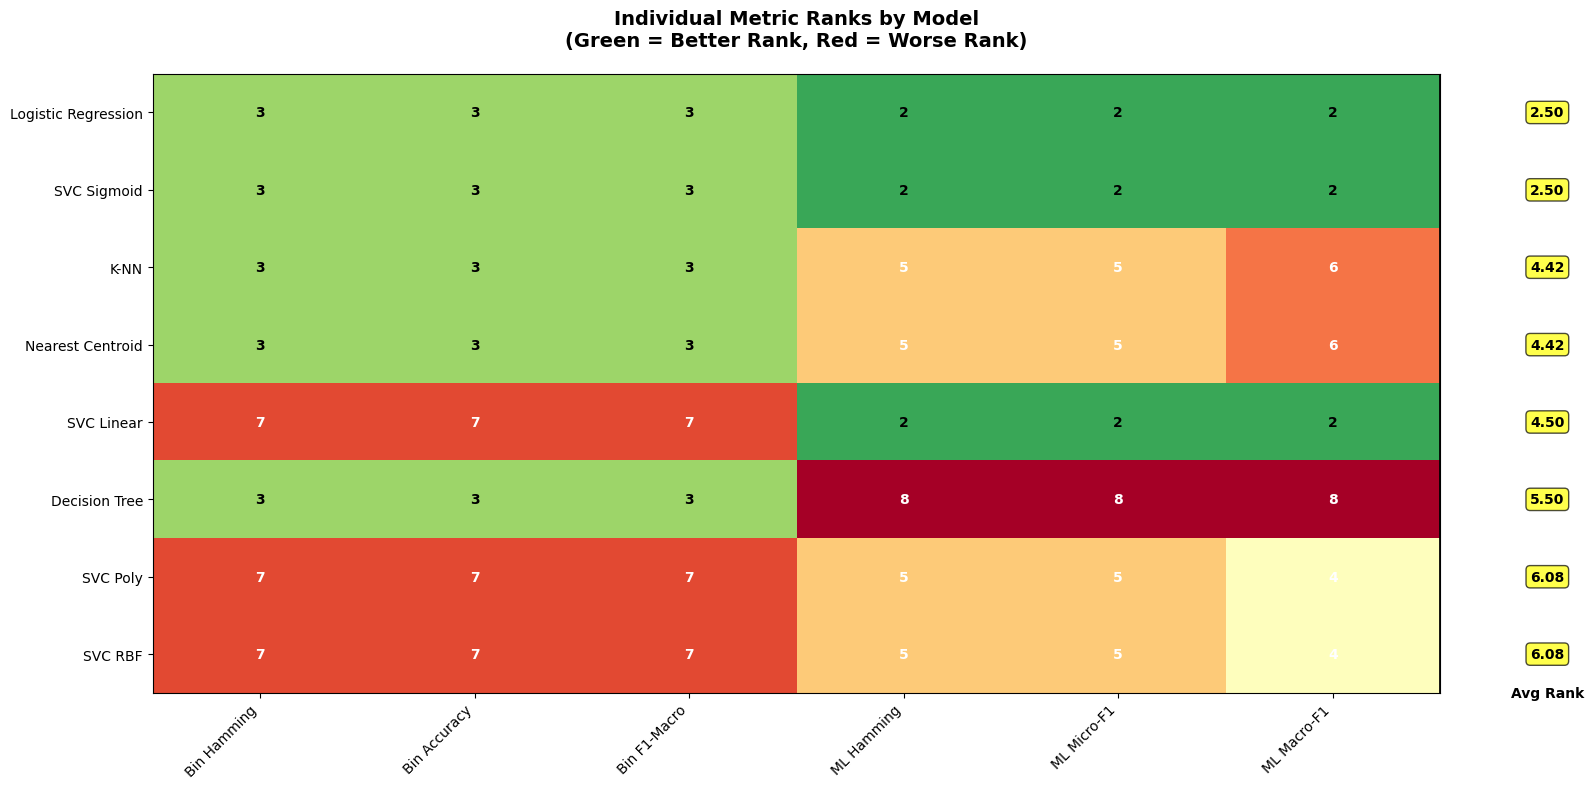

In [108]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Your data
binary_data = {
    'Model': ['Logistic Regression', 'K-NN', 'Nearest Centroid', 'SVC Linear', 
              'SVC Poly', 'SVC RBF', 'SVC Sigmoid', 'Decision Tree'],
    'Binary_Hamming_Loss': [0.100, 0.100, 0.100, 0.200, 0.200, 0.200, 0.100, 0.100],
    'Binary_Accuracy': [0.90, 0.90, 0.90, 0.80, 0.80, 0.80, 0.90, 0.90],
    'Binary_F1_Macro': [0.87, 0.87, 0.87, 0.76, 0.76, 0.76, 0.87, 0.87],
}

multilabel_data = {
    'Model': ['Logistic Regression', 'K-NN', 'Nearest Centroid', 'SVC Linear', 
              'SVC Poly', 'SVC RBF', 'SVC Sigmoid', 'Decision Tree'],
    'MultiLabel_Hamming_Loss': [0.000, 0.024, 0.024, 0.000, 0.024, 0.024, 0.000, 0.071],
    'MultiLabel_Micro_F1': [1.00, 0.97, 0.97, 1.00, 0.97, 0.97, 1.00, 0.90],
    'MultiLabel_Macro_F1': [1.00, 0.95, 0.95, 1.00, 0.97, 0.97, 1.00, 0.89],
}

# Create DataFrames and merge
df = pd.DataFrame(binary_data).merge(pd.DataFrame(multilabel_data), on='Model')

# Calculate ranks
metrics = ['Binary_Hamming_Loss', 'Binary_Accuracy', 'Binary_F1_Macro', 
           'MultiLabel_Hamming_Loss', 'MultiLabel_Micro_F1', 'MultiLabel_Macro_F1']
metric_names = ['Bin Hamming', 'Bin Accuracy', 'Bin F1-Macro', 
                'ML Hamming', 'ML Micro-F1', 'ML Macro-F1']

for metric in metrics:
    if 'Hamming_Loss' in metric:
        df[f'{metric}_Rank'] = df[metric].rank(ascending=True)
    else:
        df[f'{metric}_Rank'] = df[metric].rank(ascending=False)

# Calculate average rank
rank_columns = [f'{metric}_Rank' for metric in metrics]
df['Average_Rank'] = df[rank_columns].mean(axis=1)
df['Overall_Rank'] = df['Average_Rank'].rank(ascending=True)

# Sort by average rank
df_sorted = df.sort_values('Average_Rank')

# Create the visualization
fig, ax = plt.subplots(figsize=(16, 8))

# Individual ranks heatmap
rank_data = []
for _, row in df_sorted.iterrows():
    ranks = [row[f'{metric}_Rank'] for metric in metrics]
    rank_data.append(ranks)

rank_data = np.array(rank_data)
models = df_sorted['Model'].tolist()

im = ax.imshow(rank_data, cmap='RdYlGn_r', aspect='auto', vmin=1, vmax=8)
ax.set_xticks(range(len(metric_names)))
ax.set_xticklabels(metric_names, rotation=45, ha='right')
ax.set_yticks(range(len(models)))
ax.set_yticklabels(models)
ax.set_title('Individual Metric Ranks by Model\n(Green = Better Rank, Red = Worse Rank)', 
              fontsize=14, pad=20, weight='bold')

# Add rank values to heatmap
for i in range(len(models)):
    for j in range(len(metrics)):
        ax.text(j, i, f'{int(rank_data[i, j])}', 
                ha='center', va='center', fontweight='bold', 
                color='white' if rank_data[i, j] > 4 else 'black')

# Add average rank column with lower position
avg_ranks = df_sorted['Average_Rank'].values
for i, avg_rank in enumerate(avg_ranks):
    ax.text(len(metrics), i, f'{avg_rank:.2f}', 
            ha='center', va='center', fontweight='bold', fontsize=10,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

ax.axvline(x=len(metrics)-0.5, color='black', linewidth=2)
ax.text(len(metrics), len(models)-0.5, 'Avg Rank', 
         ha='center', va='center', fontweight='bold', rotation=0)

plt.tight_layout()
plt.show()